In [1]:
%matplotlib inline

import cosima_cookbook as cc
from cosima_cookbook import distributed as ccd
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import glob,os
import cmocean.cm as cmocean

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client(memory_limit='500GiB') #memory_limit='500GiB'
client

2024-04-17 11:17:15,482 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 500GiB due to system memory limit of 251.18 GiB
2024-04-17 11:17:15,486 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 500GiB due to system memory limit of 251.18 GiB
2024-04-17 11:17:15,489 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 500GiB due to system memory limit of 251.18 GiB
2024-04-17 11:17:15,492 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 500GiB due to system memory limit of 251.18 GiB
2024-04-17 11:17:15,495 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 500GiB due to system memory limit of 251.18 GiB
2024-04-17 11:17:15,498 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 500GiB due to system memory limit of 251.18 GiB
2024-04-17 11:17:15,501 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 500GiB due to system memory limit of 251.18 GiB


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 1.72 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45075,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 1.72 TiB
Comm: tcp://127.0.0.1:36805,Total threads: 4
Dashboard: /proxy/42933/status,Memory: 251.18 GiB
Nanny: tcp://127.0.0.1:43365,


In [3]:
	session = cc.database.create_session()
	
	
	imm=1
	monthdays = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
	month = str(int(imm))
	month = month.zfill(2)
	year = str(1974)
	start_time=year+'-'+month  
	#Start_time0 and end_time0 are for importing the daily transport, and it ahsthe number of days in the month    
	start_time0=year+'-'+month +'-01'     
	end_time0=year+'-'+month +'-' + str(monthdays[int(int(imm)-1)])
	print(start_time0) 
	print(end_time0) 
	exp = '01deg_jra55v140_iaf_cycle3'
	
	print("Start date =" + start_time) 
	year2=str(int(start_time[0:4])+1)
	month2=str(int(start_time[5:7])+1)
	month2=str(int(month2))
	month2 = month2.zfill(2)    
	print("month2 is =" + month2) 
	print("year2 is =" + str(year2))     
	
	imon = int(imm)
	if imon <12:
		end_time=year+'-'+month2
	else:
		end_time=year2+'-01'
	
	print("End date =" + end_time) 
	
	
	time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))
	
	# reference density value:
	rho_0 = 1035.0
	# specific heat capacity of sea water:
	cp = 3992.1
	lat_range = slice(-90,-59)
	
	isobath_depth = 1000
	
	# pick a freezing point temp:
	temp_freezing = -3.82
	
	

1974-01-01
1974-01-31
Start date =1974-01
month2 is =02
year2 is =1975
End date =1974-02


In [4]:
	
	print("importing isobath mask")
	outfile = '/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_'+str(isobath_depth)+'m.npz'
	data = np.load(outfile)
	mask_y_transport = data['mask_y_transport']
	mask_x_transport = data['mask_x_transport']
	mask_y_transport_numbered = data['mask_y_transport_numbered']
	mask_x_transport_numbered = data['mask_x_transport_numbered']
	
	yt_ocean = cc.querying.getvar(exp,'yt_ocean',session,n=1)
	yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
	yu_ocean = cc.querying.getvar(exp,'yu_ocean',session,n=1)
	yu_ocean = yu_ocean.sel(yu_ocean=lat_range)
	xt_ocean = cc.querying.getvar(exp,'xt_ocean',session,n=1)
	xu_ocean = cc.querying.getvar(exp,'xu_ocean',session,n=1)   
	
	mask_x_transport =xr.DataArray(data['mask_x_transport']).assign_coords({"dim_0": np.array(yt_ocean),"dim_1": np.array(xu_ocean)}).rename(dim_0="yt_ocean",dim_1="xu_ocean")
	mask_y_transport =xr.DataArray(data['mask_y_transport']).assign_coords({"dim_0": np.array(yt_ocean),"dim_1": np.array(xu_ocean)}).rename(dim_0="yu_ocean",dim_1="xt_ocean")
	mask_x_transport_numbered =xr.DataArray(data['mask_x_transport_numbered']).assign_coords({"dim_0": np.array(yt_ocean),"dim_1": np.array(xt_ocean)}).rename(dim_0="yt_ocean",dim_1="xt_ocean")
	mask_y_transport_numbered =xr.DataArray(data['mask_y_transport_numbered']).assign_coords({"dim_0": np.array(yt_ocean),"dim_1": np.array(xt_ocean)}).rename(dim_0="yt_ocean",dim_1="xt_ocean")
	
	num_points = int(np.maximum(np.max(mask_y_transport_numbered),np.max(mask_x_transport_numbered)))
	lat_along_contour = np.zeros((num_points))
	lon_along_contour = np.zeros((num_points))
	
	# locations for zonal transport:
	x_indices_masked = mask_x_transport_numbered.stack().values
	x_indices = np.sort(x_indices_masked[x_indices_masked>0])
	for count in x_indices:
		count = int(count)
		jj = int(np.where(mask_x_transport_numbered==count)[0])
		ii = int(np.where(mask_x_transport_numbered==count)[1])   
		lon_along_contour[count-1] = xu_ocean[ii].values
		lat_along_contour[count-1] = mask_x_transport_numbered.yt_ocean[jj].values
	
	# locations for meridional transport:
	y_indices_masked = mask_y_transport_numbered.stack().values
	y_indices = np.sort(y_indices_masked[y_indices_masked>0])
	for count in y_indices:
		count = int(count)
		jj = np.where(mask_y_transport_numbered==count)[0]
		ii = np.where(mask_y_transport_numbered==count)[1]
		lon_along_contour[count-1] = mask_x_transport_numbered.xt_ocean[ii].values
		lat_along_contour[count-1] = yu_ocean[jj].values
	

importing isobath mask


In [6]:
	
	print("importing temp_xflux and temp_yflux")
	
	
	#importing all heat transports calculated offline
	#src_HT='/scratch/v45/wf4500/model_data/OM2/IAF/temp_fluxes/daily_z'
	src_HT='/g/data/x77/wf4500/ASC_project/Offline_tempflux/IAF/daily_heat_transport_z'
	glx =glob.glob(src_HT + "/temp_xflux_from_daily_****.nc")
	glx=sorted(glx)
	temp_xflux=xr.open_mfdataset(glx, concat_dim='time', combine='nested')
	#temp_xflux=xr.open_dataset("/scratch/v45/wf4500/model_data/OM2/IAF/temp_fluxes/daily_z/tempC_xflux_from_daily_1958_02.nc")
	
	
	gly =glob.glob(src_HT + "/temp_yflux_from_daily_****.nc")
	gly=sorted(gly)
	temp_yflux=xr.open_mfdataset(gly, concat_dim='time', combine='nested')    
	# #temp_yflux=xr.open_dataset("/scratch/v45/wf4500/model_data/OM2/IAF/temp_fluxes/daily_z/tempC_yflux_from_daily_1958_02.nc")    	    
	
	
	
	
	# Getting only the times that we want
	temp_xflux = temp_xflux.sel(time=slice(start_time0,end_time0)).rename(x_ocean='xu_ocean',y_ocean='yt_ocean')
	temp_yflux = temp_yflux.sel(time=slice(start_time0,end_time0)).rename(x_ocean='xt_ocean',y_ocean='yu_ocean')
	
	ndays_month=int(np.size(temp_xflux.time));
	

importing temp_xflux and temp_yflux


In [7]:
	
	temp_yflux = temp_yflux.temp_yflux*cp*rho_0
	temp_xflux = temp_xflux.temp_xflux*cp*rho_0
	

In [8]:
	
	# save a long term average of vhrho_nt and uhrho_et:
	outpath = '/g/data/x77/wf4500/ASC_project/uhrho_vhrho_'+start_time+'.nc'
	# check if already exists:
	if os.path.exists(outpath):
		average_transports = xr.open_dataset(outpath)
		# extract arrays from dataset:
		uhrho_et = average_transports.uhrho_et
		vhrho_nt = average_transports.vhrho_nt
	else:
		vhrho_nt = cc.querying.getvar(exp,'vhrho_nt',session,ncfile='%daily%',start_time=start_time,end_time=end_time).sel(time=slice(start_time,end_time))
		uhrho_et = cc.querying.getvar(exp,'uhrho_et',session,ncfile='%daily%',start_time=start_time,end_time=end_time).sel(time=slice(start_time,end_time))
		
		vhrho_nt = vhrho_nt.sel(yt_ocean=lat_range).sel(time=slice(start_time0,end_time0))
		uhrho_et = uhrho_et.sel(yt_ocean=lat_range).sel(time=slice(start_time0,end_time0))
		
		vhrho_nttime=vhrho_nt.time
		
		
		outpath = '/g/data/x77/wf4500/ASC_project/model_data/access-om2/'+exp+'/Antarctic_cross_slope/Daily/uhrho_vhrho_'+start_time+'.nc'
		ds = xr.Dataset({'vhrho_nt': vhrho_nt,'uhrho_et':uhrho_et})
		#del ds.vhrho_nt.attrs['time_bounds']
		#del ds.uhrho_et.attrs['time_bounds']
		#ds.to_netcdf(outpath)
		#ds.close()
	print('Daily data being calculated for month =  ...')
	print(vhrho_nttime)
	

HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 1:
  #000: H5A.c line 528 in H5Aopen_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #001: H5VLcallback.c line 1091 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #002: H5VLcallback.c line 1058 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: H5VLnative_attr.c line 130 in H5VL__native_attr_open(): can't open attribute
    major: Attribute
    minor: Can't open object
  #004: H5Aint.c line 545 in H5A__open_by_name(): unable to load attribute info from object header
    major: Attribute
    minor: Unable to initialize object
  #005: H5Oattribute.c line 476 in H5O__attr_open_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #006: H5Adense.c line 394 in H5A__dense_open(): can't locate attribute in name index
    major: Attribute
    minor: Object not 

Daily data being calculated for month =  ...
<xarray.DataArray 'time' (time: 31)>
array(['1974-01-01T12:00:00.000000000', '1974-01-02T12:00:00.000000000',
       '1974-01-03T12:00:00.000000000', '1974-01-04T12:00:00.000000000',
       '1974-01-05T12:00:00.000000000', '1974-01-06T12:00:00.000000000',
       '1974-01-07T12:00:00.000000000', '1974-01-08T12:00:00.000000000',
       '1974-01-09T12:00:00.000000000', '1974-01-10T12:00:00.000000000',
       '1974-01-11T12:00:00.000000000', '1974-01-12T12:00:00.000000000',
       '1974-01-13T12:00:00.000000000', '1974-01-14T12:00:00.000000000',
       '1974-01-15T12:00:00.000000000', '1974-01-16T12:00:00.000000000',
       '1974-01-17T12:00:00.000000000', '1974-01-18T12:00:00.000000000',
       '1974-01-19T12:00:00.000000000', '1974-01-20T12:00:00.000000000',
       '1974-01-21T12:00:00.000000000', '1974-01-22T12:00:00.000000000',
       '1974-01-23T12:00:00.000000000', '1974-01-24T12:00:00.000000000',
       '1974-01-25T12:00:00.000000000', '1

In [9]:
	
	import os
	#outpath = '/g/data/x77/wf4500/ASC_project/model_data/access-om2/'+exp+'/Antarctic_cross_slope/Daily/uhrho_vhrho_'+start_time+'.nc'
	#ds = xr.open_dataset(outpath)
	vhrho_nt = ds['vhrho_nt']
	uhrho_et = ds['uhrho_et']
	
	# subtract freezing point heat transport:
	yt_ocean = cc.querying.getvar('01deg_jra55v13_ryf9091','yt_ocean',session,n=1)
	dxu = cc.querying.getvar('01deg_jra55v13_ryf9091','dxu',session,n=1)
	dyt = cc.querying.getvar('01deg_jra55v13_ryf9091','dyt',session,n=1)
	# give dxu and dyt correct coordinates:
	dxu.coords['nj'] = yt_ocean.values
	dxu.coords['ni'] = xt_ocean['xt_ocean'].values
	dxu = dxu.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
	dyt.coords['nj'] = yt_ocean.values
	dyt.coords['ni'] = xt_ocean['xt_ocean'].values
	dyt = dyt.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
	# select latitude range:
	dxu = dxu.sel(yt_ocean=lat_range)
	dyt = dyt.sel(yt_ocean=lat_range)
	
	# Note that in newer mom5 versions this could also be done with ty_trans_int_z, 
	# but there is a problem with this diagnostic in older runs, and even
	# using ty_trans, there is a slight difference. Not sure why?
	
	# Note vhrho_nt is v*dz*1035 and is positioned on north centre edge of t-cell.
	# sum in depth:
	vhrho_nt = vhrho_nt
	uhrho_et = uhrho_et
	# convert to transport:
	vhrho_nt = vhrho_nt*dxu/rho_0
	uhrho_et = uhrho_et*dyt/rho_0
	
	# overwrite coords, so we can add the freezing point (with uhrho_et and vhrho_nt) without problems:
	yu_ocean = cc.querying.getvar(exp,'yu_ocean',session,n=1)
	yu_ocean = yu_ocean.sel(yu_ocean=lat_range)
	vhrho_nt.coords['yt_ocean'] = yu_ocean.values
	vhrho_nt = vhrho_nt.rename(({'yt_ocean':'yu_ocean'}))
	uhrho_et.coords['xt_ocean'] = xu_ocean.values
	uhrho_et = uhrho_et.rename(({'xt_ocean':'xu_ocean'}))
	
	freezing_point_heat_trans_zonal = cp*rho_0*uhrho_et*temp_freezing
	freezing_point_heat_trans_meridional = cp*rho_0*vhrho_nt*temp_freezing
	

HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 1:
  #000: H5A.c line 528 in H5Aopen_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #001: H5VLcallback.c line 1091 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #002: H5VLcallback.c line 1058 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: H5VLnative_attr.c line 130 in H5VL__native_attr_open(): can't open attribute
    major: Attribute
    minor: Can't open object
  #004: H5Aint.c line 545 in H5A__open_by_name(): unable to load attribute info from object header
    major: Attribute
    minor: Unable to initialize object
  #005: H5Oattribute.c line 494 in H5O__attr_open_by_name(): can't locate attribute: '_QuantizeBitGroomNumberOfSignificantDigits'
    major: Attribute
    minor: Object not found
HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 1:
  #000: H5A.c line 528 in H5Ao

In [10]:
	
	freezing_point_heat_trans_meridional.load()
	temp_yflux.load()
	temp_xflux.load()
	freezing_point_heat_trans_zonal.load()
	

HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 1:
  #000: H5A.c line 528 in H5Aopen_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #001: H5VLcallback.c line 1091 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #002: H5VLcallback.c line 1058 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: H5VLnative_attr.c line 130 in H5VL__native_attr_open(): can't open attribute
    major: Attribute
    minor: Can't open object
  #004: H5Aint.c line 545 in H5A__open_by_name(): unable to load attribute info from object header
    major: Attribute
    minor: Unable to initialize object
  #005: H5Oattribute.c line 494 in H5O__attr_open_by_name(): can't locate attribute: '_QuantizeBitGroomNumberOfSignificantDigits'
    major: Attribute
    minor: Object not found
HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 1:
  #000: H5A.c line 528 in H5Ao

<xarray.DataArray (time: 31, st_ocean: 75, yt_ocean: 510, xu_ocean: 3600)>
array([[[[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [-6.26329498e+09, -5.44232397e+09, -5.10931507e+09, ...,
          -1.00691149e+10, -8.82135040e+09, -7.50018560e+09],
         [-1.09935288e+10, -9.78472960e+09, -8.78828954e+09, ...,
          -1.34927995e+10, -1.32368845e+10, -1.22077716e+10],
         [-1.37693143e+10, -1.30822103e+10, -1.18661499e+10, ...,
          -1.34912010e+10, -1.41783040e+10, -1.40746916e+10]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
...
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]]]],
      dtype=float32)
Coordinates:
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) datetime64[ns] 1974-01-01T12:00:00 ... 1974-01-31T12:00:00
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -59.14 -59.08 -59.03
    TLON      (yt_ocean, xu_ocean) float32 nan nan nan nan ... 79.75 79.85 79.95
    TLAT      (yt_ocean, xu_ocean) float32 nan nan nan ... -59.03 -59.03 -59.03
    ULON      (yt_ocean, xu_ocean) float32 nan nan nan nan ... 79.8 79.9 80.0
    ULAT      (yt_ocean, xu_ocean) float32 nan nan nan ... -59.01 -59.01 -59.01

In [11]:
	
	print("Removing freezing point heat transport")
	# compare both ways:
	temp_yflux_month = temp_yflux - freezing_point_heat_trans_meridional
	temp_xflux_month = temp_xflux - freezing_point_heat_trans_zonal
	
	# temp_yflux_with_mask_month = np.multiply(np.array(temp_yflux),np.array(mask_y_transport))
	# temp_xflux_with_mask_month = np.multiply(np.array(temp_xflux),np.array(mask_x_transport))
	
	
	#ndays_month=int(monthdays[int(int(2)-1)]) ###############################################################
	print('number of days in the current month = ' +str(ndays_month))
	

Removing freezing point heat transport
number of days in the current month = 31


In [12]:
	
	cutout_latind=510
	

In [13]:
	
	########### Import Adeles 1km contour on X,Y grid                
	outfile = '/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_'+str(isobath_depth)+'m.npz'
	data = np.load(outfile)
	mask_y_transport = data['mask_y_transport']; 
	mask_y_transport=mask_y_transport[:cutout_latind,:]       ##############################
	mask_x_transport = data['mask_x_transport']; 
	mask_x_transport=mask_x_transport[:cutout_latind,:]		################################
	mask_y_transport_numbered = data['mask_y_transport_numbered']
	mask_y_transport_numbered=mask_y_transport_numbered[:cutout_latind,:]		################################
	mask_x_transport_numbered = data['mask_x_transport_numbered']
	mask_x_transport_numbered=mask_x_transport_numbered[:cutout_latind,:]		################################
	
	
	#cutting the matrices
	ylength= np.shape(mask_x_transport)[0]
	
	
	yt_ocean0 = cc.querying.getvar(exp,'yt_ocean',session,n=1)
	yt_ocean0 = yt_ocean0.isel(yt_ocean=slice(0,ylength))
	yu_ocean0 = cc.querying.getvar(exp,'yu_ocean',session,n=1)
	yu_ocean0 = yu_ocean0.isel(yu_ocean=slice(0,ylength))
	xt_ocean0 = cc.querying.getvar(exp,'xt_ocean',session,n=1)
	xu_ocean0 = cc.querying.getvar(exp,'xu_ocean',session,n=1)
	

HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 1:
  #000: H5A.c line 528 in H5Aopen_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #001: H5VLcallback.c line 1091 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #002: H5VLcallback.c line 1058 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: H5VLnative_attr.c line 130 in H5VL__native_attr_open(): can't open attribute
    major: Attribute
    minor: Can't open object
  #004: H5Aint.c line 545 in H5A__open_by_name(): unable to load attribute info from object header
    major: Attribute
    minor: Unable to initialize object
  #005: H5Oattribute.c line 494 in H5O__attr_open_by_name(): can't locate attribute: '_QuantizeBitGroomNumberOfSignificantDigits'
    major: Attribute
    minor: Object not found
HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 1:
  #000: H5A.c line 528 in H5Ao

In [14]:
	
	mask_x_transport =xr.DataArray(data['mask_x_transport']).assign_coords({"dim_0": np.array(yt_ocean0),"dim_1": np.array(xu_ocean0)}).rename(dim_0="y_ocean",dim_1="x_ocean")
	mask_x_transport=mask_x_transport[:cutout_latind,:]       ##############################
	mask_y_transport =xr.DataArray(data['mask_y_transport']).assign_coords({"dim_0": np.array(yu_ocean0),"dim_1": np.array(xt_ocean0)}).rename(dim_0="y_ocean",dim_1="x_ocean")
	mask_y_transport=mask_y_transport[:cutout_latind,:]		################################		
	mask_x_transport_numbered =xr.DataArray(data['mask_x_transport_numbered']).assign_coords({"dim_0": np.array(yt_ocean0),"dim_1": np.array(xu_ocean0)}).rename(dim_0="y_ocean",dim_1="x_ocean")          ##################
	mask_x_transport_numbered=mask_x_transport_numbered[:cutout_latind,:]		################################		
	mask_y_transport_numbered =xr.DataArray(data['mask_y_transport_numbered']).assign_coords({"dim_0": np.array(yu_ocean0),"dim_1": np.array(xt_ocean0)}).rename(dim_0="y_ocean",dim_1="x_ocean")          ##################
	mask_y_transport_numbered=mask_y_transport_numbered[:cutout_latind,:]		################################
	
	num_points = int(np.maximum(np.max(mask_y_transport_numbered),np.max(mask_x_transport_numbered)))                
	
	
	
	
	
	############### Getting the lon,lat along contour in the X,Y contour
	lat_along_contour = np.zeros((num_points))
	lon_along_contour = np.zeros((num_points))
	# locations for zonal transport:
	x_indices_masked = mask_x_transport_numbered.stack().values
	x_indices = np.sort(x_indices_masked[x_indices_masked>0])
	for count in x_indices:
		count = int(count)
		jj = int(np.where(mask_x_transport_numbered==count)[0])
		ii = int(np.where(mask_x_transport_numbered==count)[1])   
		lon_along_contour[count-1] = xu_ocean0[ii].values
		lat_along_contour[count-1] = mask_x_transport_numbered.y_ocean[jj].values
		
	# locations for meridional transport:
	y_indices_masked = mask_y_transport_numbered.stack().values
	y_indices = np.sort(y_indices_masked[y_indices_masked>0])
	for count in y_indices:
		count = int(count)
		jj = np.where(mask_y_transport_numbered==count)[0]
		ii = np.where(mask_y_transport_numbered==count)[1]
		lon_along_contour[count-1] = mask_x_transport_numbered.x_ocean[ii].values           ##################          ##################          ##################          ##################          ##################          ##################
		lat_along_contour[count-1] = yu_ocean0[jj].values
	

In [15]:
	
	temp_yflux_with_mask_month=temp_yflux_month
	temp_yflux_with_mask_month['yu_ocean'] = np.array(mask_y_transport.y_ocean)
	temp_yflux_with_mask_month['xt_ocean'] = np.array(mask_y_transport.x_ocean)
	temp_yflux_with_mask_month = temp_yflux_with_mask_month.rename(yu_ocean='y_ocean',xt_ocean='x_ocean')*mask_y_transport
	
	temp_xflux_with_mask_month=temp_xflux_month
	temp_xflux_with_mask_month['yt_ocean'] = np.array(mask_y_transport.y_ocean)
	temp_xflux_with_mask_month['xu_ocean'] = np.array(mask_y_transport.x_ocean)
	temp_xflux_with_mask_month = temp_xflux_with_mask_month.rename(yt_ocean='y_ocean',xu_ocean='x_ocean')*mask_y_transport
	
	
	temp_yflux_with_mask_month['y_ocean']=np.array(mask_y_transport_numbered.y_ocean)
	temp_yflux_with_mask_month['x_ocean']=np.array(mask_y_transport_numbered.x_ocean)
	
	temp_xflux_with_mask_month['y_ocean']=np.array(mask_x_transport_numbered.y_ocean)
	temp_xflux_with_mask_month['x_ocean']=np.array(mask_x_transport_numbered.x_ocean)
	
	

Do not need to add this line as I loaded the daa before

In [16]:
	# # #there is a new problem with dimensions here. what is it? i dunno, gotta freaking check each dimension
	# temp_yflux_month = temp_yflux_month.load()
	# temp_xflux_month = temp_xflux_month.load()

In [17]:
	
	# Create the contour order data-array. Note that in this procedure the x-grid counts have x-grid
	#   dimensions and the y-grid counts have y-grid dimensions, but these are implicit, the dimension 
	#   *names* are kept general across the counts, the generic y_ocean, x_ocean, so that concatening works
	#   but we dont double up with numerous counts for one lat/lon point.
	
	# stack contour data into 1d:
	mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
	mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)
	
	mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
	mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)
	
	contour_ordering = xr.concat((mask_x_numbered_1d, mask_y_numbered_1d), dim = 'contour_index')
	contour_ordering = contour_ordering.sortby(contour_ordering)
	contour_index_array = np.arange(1, len(contour_ordering)+1)
	

for temp_xflux

In [18]:
	
	temp_yflux_month['yu_ocean']=np.array(mask_y_transport_numbered.y_ocean)
	temp_yflux_month['xt_ocean']=np.array(mask_y_transport_numbered.x_ocean)
	
	temp_xflux_month['yt_ocean']=np.array(mask_x_transport_numbered.y_ocean)
	temp_xflux_month['xu_ocean']=np.array(mask_x_transport_numbered.x_ocean)
	

In [19]:
	
	# stack transports into 1d and drop any points not on contour:
	x_along_1d = mask_x_transport.stack(contour_index = ['y_ocean', 'x_ocean'])
	x_along_1d = x_along_1d.where(mask_x_numbered_1d>0, drop = True)
	y_along_1d = mask_y_transport.stack(contour_index = ['y_ocean', 'x_ocean'])
	y_along_1d = y_along_1d.where(mask_y_numbered_1d>0, drop = True)
	
	# combine all points on contour, to obtain a matrix with transport directions:
	transp_dir = xr.concat((x_along_1d, y_along_1d), dim = 'contour_index')
	transp_dir = transp_dir.sortby(contour_ordering)
	transp_dir.coords['contour_index'] = contour_index_array
	transp_dir = transp_dir.load()
	

In [20]:
	
	## We could also loop in time if we didn't want the time average. Initialise a data array and fill in data by looping in time.
	# stack transports into 1d and drop any points not on contour:
	x_along_1d = temp_xflux_month.rename(yt_ocean='y_ocean',xu_ocean='x_ocean').stack(contour_index = ['y_ocean', 'x_ocean'])
	x_along_1d = x_along_1d.where(mask_x_numbered_1d>0, drop = True)
	y_along_1d = temp_yflux_month.rename(yu_ocean='y_ocean',xt_ocean='x_ocean').stack(contour_index = ['y_ocean', 'x_ocean'])
	y_along_1d = y_along_1d.where(mask_y_numbered_1d>0, drop = True)
	
	# combine all points on contour:
	heat_transp_across_contour = xr.concat((x_along_1d, y_along_1d), dim = 'contour_index')
	heat_transp_across_contour = heat_transp_across_contour.sortby(contour_ordering)
	heat_transp_across_contour.coords['contour_index'] = contour_index_array
	heat_transp_across_contour = (heat_transp_across_contour*transp_dir).load()
	

In [21]:
	
	
	print('defining paralelized loop')    
	

defining paralelized loop


In [22]:
	
	# convert to longitude coordinate and average into 3 degree longitude bins:
	# in degrees:
	bin_width = 2.5
	bin_spacing = 0.25
	lon_west = -280
	lon_east = 80
	
	# new coordinate and midpoints of longitude bins:
	full_lon_coord = np.arange(lon_west,lon_east+bin_spacing,bin_spacing)
	lon_bin_midpoints = np.arange(lon_west+bin_width/2,lon_east-bin_width/2,bin_spacing)
	n_bin_edges = len(full_lon_coord)
	
	# sum into longitude bins:
	# need to be very careful of loops, we can't just mask over longitude values, but instead pick indices 
	# on the isobath contour and sum continously along contour between defined indices.
	# (i.e. lon_along_contour is not monotonic)
	# find points on contour to define edges of longitude bins:
	bin_edge_indices = np.zeros(n_bin_edges)
	for lon_bin in range(n_bin_edges-1):
		# find first isobath point that has the right longitude:
		first_point = np.where(lon_along_contour>=full_lon_coord[lon_bin])[0][0]
		# then find all other isobath points with the same longitude as that first point:
		same_lon_points = np.where(lon_along_contour==lon_along_contour[first_point])[0]
		# we want the most southerly of these points on the same longitude line:
		bin_edge_indices[lon_bin] = same_lon_points[np.argmin(lat_along_contour[same_lon_points])]
		
	# define east/west edges:
	bin_edge_indices = bin_edge_indices.astype(int)
	bin_edge_indices_west = bin_edge_indices[:-int(bin_width/bin_spacing)-1]
	bin_edge_indices_east = bin_edge_indices[int(bin_width/bin_spacing):-1]
	n_bins = len(bin_edge_indices_west)
	
	
	lat_bin_midpoints = np.zeros(n_bins)
	for lon_bin in range(n_bins):
		# find nearest isobath point:
		lon_index = np.where(lon_along_contour>=lon_bin_midpoints[lon_bin])[0][0]
		lat_bin_midpoints[lon_bin] = lat_along_contour[lon_index]
	

In [23]:
	
	# sum heat transport from isobath coord into new longitude coord:
	cross_slope_heat_trans = np.zeros([ndays_month,75,n_bins])
	for lon_bin in range(n_bins):
		heat_trans_this_bin0 = heat_transp_across_contour[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
		cross_slope_heat_trans[:,:,lon_bin] = np.sum(heat_trans_this_bin0,axis=2)
	
	#cross_slope_heat_trans=np.zeros([ndays_month,75,int(np.size(lon_bin_midpoints))])	
	#cross_slope_heat_trans[ndindex][nzindex]=cross_slope_heat_trans0
	# find average latitude of each bin, so we can plot back on the isobath:
	lat_bin_midpoints = np.zeros(n_bins)
	for lon_bin in range(n_bins):
		# find nearest isobath point:
		lon_index = np.where(lon_along_contour>=lon_bin_midpoints[lon_bin])[0][0]
		lat_bin_midpoints[lon_bin] = lat_along_contour[lon_index]
	
	
	print('Calculating Zonal heat convergence')
	# Need to make sure the zonal boundaries here match exactly with the zonal boundaries used for the 
	# longitude averaging above, by using same bin_edge_indices.
	# Just check if isobath point is on x or y grid. if x, sum up to this point from south.
	# if on y grid, sum zonal transport on nearest u grid point to west.
	
	zonal_heat_trans_west = np.zeros([ndays_month,75,n_bins])
	for lon_bin in range(n_bins):
		# west limit:
		# reset these to False:
		on_x_grid = False
		on_y_grid = False
		# mask_x_transport_numbered etc indexing starts from 1 not 0, so add 1:
		isobath_west_index = int(bin_edge_indices_west[lon_bin]+1)
		# check if the point is on the x or y transport grid:
		if len(np.where(mask_x_transport_numbered==isobath_west_index)[0])>0:
			on_x_grid = True
			jj = int(np.where(mask_x_transport_numbered==isobath_west_index)[0])
			ii = int(np.where(mask_x_transport_numbered==isobath_west_index)[1])
		elif len(np.where(mask_y_transport_numbered==isobath_west_index)[0])>0:
			on_y_grid = True
			jj = int(np.where(mask_y_transport_numbered==isobath_west_index)[0])
			ii = int(np.where(mask_y_transport_numbered==isobath_west_index)[1])               
		if on_x_grid == True:
			zonal_heat_trans_west[:,:,lon_bin] = np.sum(temp_xflux_month[:,:,:jj,ii],axis=2)
		#in this case we want transport half a grid point to the west:
		elif on_y_grid == True:
			# careful if ii=0, then we need heat trans from lon=80, because at limit of zonal grid
			if ii==0:
				zonal_heat_trans_west[:,:,lon_bin] = np.sum(temp_xflux_month[:,:,:jj+1,-1],axis=2)
			else:
				zonal_heat_trans_west[:,:,lon_bin] = np.sum(temp_xflux_month[:,:,:jj+1,ii-1],axis=2)
	
	zonal_heat_trans_east = np.zeros([ndays_month,75,n_bins])
	for lon_bin in range(n_bins):
		# east limit:
		# reset these to False:
		on_x_grid = False
		on_y_grid = False
		# mask_x_transport_numbered etc indexing starts from 1 not 0, so add 1:
		isobath_east_index = int(bin_edge_indices_east[lon_bin]+1)
		# check if the point is on the x or y transport grid:
		if len(np.where(mask_x_transport_numbered==isobath_east_index)[0])>0:
			on_x_grid = True
			jj = int(np.where(mask_x_transport_numbered==isobath_east_index)[0])
			ii = int(np.where(mask_x_transport_numbered==isobath_east_index)[1])
		elif len(np.where(mask_y_transport_numbered==isobath_east_index)[0])>0:
			on_y_grid = True
			jj = int(np.where(mask_y_transport_numbered==isobath_east_index)[0])
			ii = int(np.where(mask_y_transport_numbered==isobath_east_index)[1])
		if on_x_grid == True:
			zonal_heat_trans_east[:,:,lon_bin] = np.sum(temp_xflux_month[:,:,:jj,ii],axis=2)
			# in this case we want transport half a grid point to the west:
		elif on_y_grid == True:
			# wrap around to east side of grid:
			if ii==0:
				zonal_heat_trans_east[:,:,lon_bin] = np.sum(temp_xflux_month[:,:,:jj+1,-1],axis=2)
			else:
				zonal_heat_trans_east[:,:,lon_bin] = np.sum(temp_xflux_month[:,:,:jj+1,ii-1],axis=2)
	
	zonal_convergence = zonal_heat_trans_east - zonal_heat_trans_west
	
	
	
	

Calculating Zonal heat convergence


## Saving

In [24]:
	
	# PREVIOUS SAVEDIR TO LOCATE THE FILES save_dir  = '/g/data/x77/wf4500/ASC_project/ASC_speed/monthly/OM2_RYF/'
	save_dir  = '/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/Binning_test_month_z/25deg_width/Ant_cross_slope_heat_terms_offline_'+str(isobath_depth)+'m_'+ start_time+'.nc'    
	
	
	data_ZC=xr.DataArray((zonal_convergence),name="zonal_convergence",dims=["time","st_ocean","lon_bin_midpoints"])
	data_CSHT=xr.DataArray((cross_slope_heat_trans),name="binned_cross_slope_heat_trans",dims=["time","st_ocean","lon_bin_midpoints"])
	data_HT=heat_transp_across_contour
	data_HT.name='unbinned_heat_transp_across_contour'
	data_lat=xr.DataArray((lat_along_contour),name="lat_along_contour",dims=["contour_index"])
	data_lon=xr.DataArray((lon_along_contour),name="lon_along_contour",dims=["contour_index"])
	data_latbin=xr.DataArray((lat_bin_midpoints),name="lat_bin_midpoints",dims=["lon_bin_midpoints"])
	
	
	
	#data_time=xr.DataArray(Ualong.time,name="time",dims=["time"])
	
	data_to_saveuv = xr.merge([data_ZC,data_CSHT,data_HT,data_lat,data_lon,data_latbin])
	data_to_saveuv['contour_index']=heat_transp_across_contour.contour_index
	data_to_saveuv['st_ocean']=np.array(heat_transp_across_contour.st_ocean)
	data_to_saveuv['lon_bin_midpoints']=np.array(lon_bin_midpoints)
	data_to_saveuv['time']=heat_transp_across_contour.time
	data_to_saveuv.to_netcdf(save_dir)
	
	print('Finished successful')
	

Finished successful


# Checking it

This part doesnt go to the main python code

In [25]:
factor= np.float(np.sum(np.mean(heat_transp_across_contour,axis=0)) /(np.nansum(np.nansum(np.mean(cross_slope_heat_trans,axis=0),axis=0)) +
                                                     np.nansum(np.nansum(np.mean(zonal_convergence,axis=0),axis=0))))
factor

0.09955886207258223

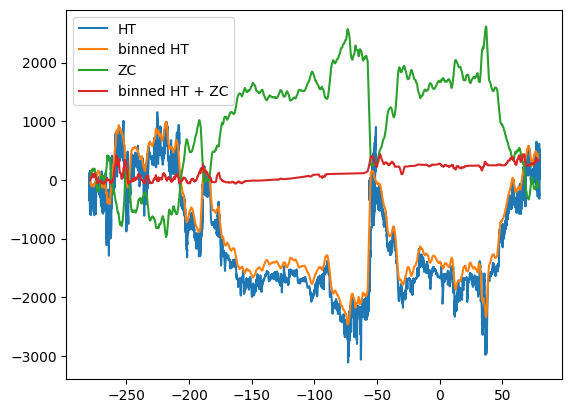

In [26]:
HT=np.cumsum(np.nansum(np.mean(heat_transp_across_contour,axis=0),axis=0))
CSHT=np.cumsum(np.nansum(np.mean(cross_slope_heat_trans,axis=0),axis=0))*factor
CSHT_ZC=np.cumsum(np.nansum(np.mean(cross_slope_heat_trans+zonal_convergence,axis=0),axis=0))*factor
ZC=np.cumsum(np.nansum(np.mean(zonal_convergence,axis=0),axis=0))*factor

plt.plot(lon_along_contour,HT/1e12,label='HT')
plt.plot(lon_bin_midpoints,CSHT/1e12,label='binned HT')
plt.plot(lon_bin_midpoints,ZC/1e12,label='ZC')
plt.plot(lon_bin_midpoints,CSHT_ZC/1e12,label='binned HT + ZC')

plt.legend()

# both the CSHT and HTAC seem ok, but the ZC is a bit weird. Is almost like a mirroed CSHT,
#so there is some large zonal compensation. In any case, I think the values are correct, so we can move on to save the output